# Figure 1

This notebook must be run within the `benchmark_env` environment.

In [89]:
library(tidyverse)
library(ggplot2)

## Figure S1A

In [90]:
geneset_sz = readr::read_tsv("outputs/geneset_sz.tsv")
table(geneset_sz$lib_name)

Rows: 3939 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): lib_name, descr
dbl (1): num_genes

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



GO_Biological_Process_2023_sample1000                       KEGG_2021_Human 
                                 1000                                   320 
                        Reactome_2022                WikiPathway_2023_Human 
                                 1818                                   801 

In [91]:
geneset_sz <- geneset_sz %>%
  mutate(lib_name = case_when(
    lib_name == "KEGG_2021_Human" ~ "KEGG",
    lib_name == "Reactome_2022" ~ "Reactome",
    lib_name == "WikiPathway_2023_Human" ~ "WikiPathways",
    lib_name == "GO_Biological_Process_2023_sample1000" ~ "GOBP(1000)",
    TRUE ~ lib_name  # Leave other values unchanged
  ))

In [46]:
head(geneset_sz)

lib_name,descr,num_genes
<chr>,<chr>,<dbl>
KEGG,ABC transporters,45
KEGG,AGE-RAGE signaling pathway in diabetic complications,100
KEGG,AMPK signaling pathway,120
KEGG,Acute myeloid leukemia,67
KEGG,Adherens junction,71
KEGG,Adipocytokine signaling pathway,69


In [47]:
unique(geneset_sz$lib_name)

[1] "KEGG"         "Reactome"     "WikiPathways" "GOBP(1000)"

In [48]:
# Count the number of gene sets per lib_name
gene_set_counts <- geneset_sz %>%
  group_by(lib_name) %>%
  summarise(num_gene_sets = n()) 
sum(gene_set_counts$num_gene_sets)
gene_set_counts

[1] 3939

lib_name,num_gene_sets
<chr>,<int>
GOBP(1000),1000
KEGG,320
Reactome,1818
WikiPathways,801


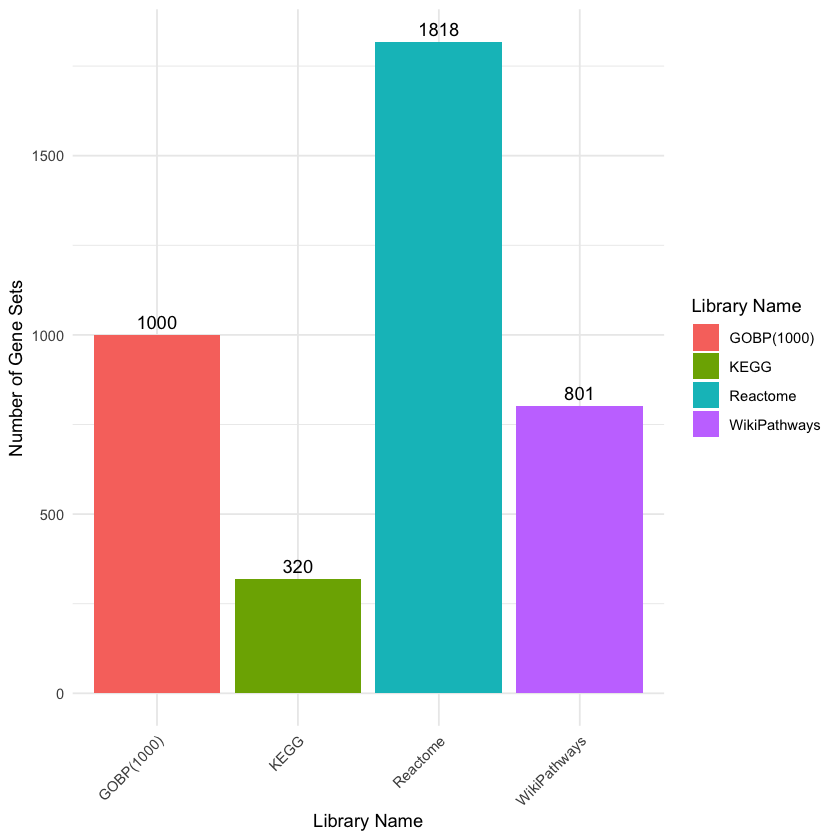

In [50]:
p <- ggplot(gene_set_counts, aes(x = lib_name, y = num_gene_sets, fill = lib_name)) +
  geom_bar(stat = "identity") +  # Create the bar plot
  geom_text(aes(label = num_gene_sets), vjust = -0.5) +  # Add the values above the bars
  theme_minimal() +  # Use a minimal theme
  labs(x = "Library Name", y = "Number of Gene Sets") +  # No title specified
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for better readability
  scale_fill_discrete(name = "Library Name")  # Change legend title to "Library Name"
ggsave(p, file="figures/figs1a.pdf", width=4, height=5)
p

# Figure S1B

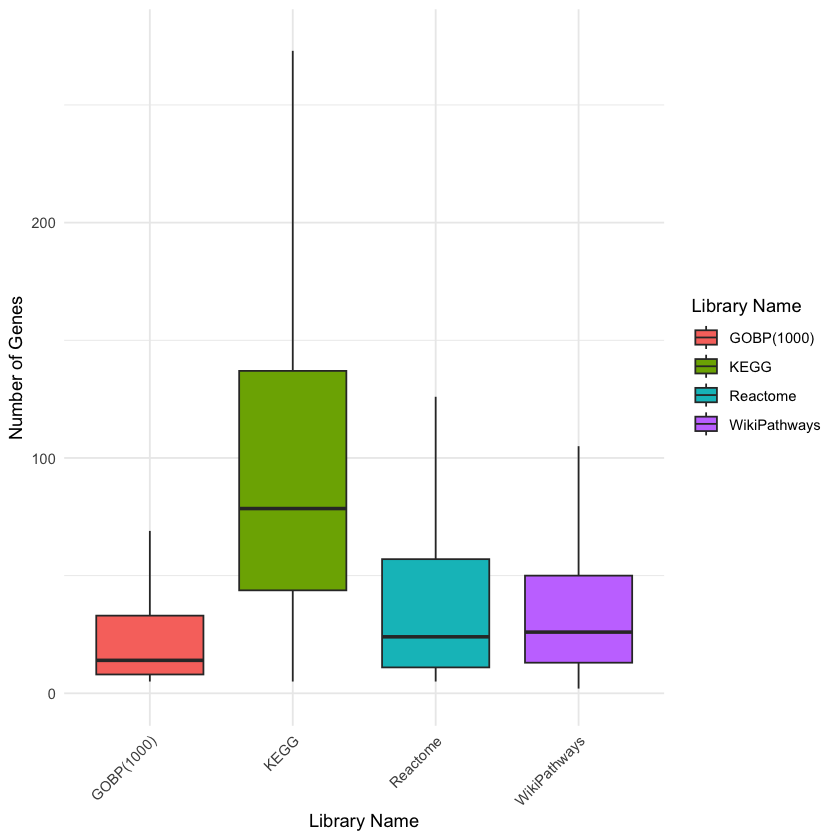

In [51]:

limits <- geneset_sz %>%
  group_by(lib_name) %>%
  summarize(ymin = max(0, quantile(num_genes, 0.25) - 1.5 * IQR(num_genes)),
            ymax = quantile(num_genes, 0.75) + 1.5 * IQR(num_genes))

# Create the boxplot with limits based on whiskers
p <- ggplot(geneset_sz, aes(x = lib_name, y = num_genes, fill=lib_name)) +
  geom_boxplot(outlier.shape = NA) +  # Create the boxplot without outliers
  theme_minimal() +  # Use a minimal theme
  labs(x = "Library Name", y = "Number of Genes") +  # Set axis labels
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for readability
  coord_cartesian(ylim = range(limits$ymin, limits$ymax)) + # Set y-axis limits based on whiskers
scale_fill_discrete(name = "Library Name") 
ggsave(p, file="figures/figs1b.pdf",width=4, height=5)

p

## Figure 1C

In [58]:
df <- readr::read_tsv("outputs/genes_overlap.tsv")
df <- df %>% filter(gene_set == "llm_genes_role")
# Step 1: Update model names
df <- df %>%
  mutate(model = case_when(
    model == "gpt-4o-mini-2024-07-18" ~ "GPT-4o mini",
    model == "gpt-3.5-turbo-0125" ~ "GPT-3.5",
    model == "gpt-4o-2024-08-06" ~ "GPT-4o",
    TRUE ~ model  # Leave other values unchanged
  ))

# Step 2: Update database names
df <- df %>%
  mutate(database = case_when(
    database == "KEGG_2021_Human" ~ "KEGG",
    database == "Reactome_2022" ~ "Reactome",
    database == "WikiPathway_2023_Human" ~ "WikiPathways",
    database == "GO_Biological_Process_2023_sample1000" ~ "GOBP(1000)",
    TRUE ~ database  # Leave other values unchanged
  ))

# Step 3: Set the order of the 'model' factor
df <- df %>%
  mutate(model = factor(model, levels = c("GPT-3.5", "GPT-4o mini", "GPT-4o")))


Rows: 82719 Columns: 17
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): database, model, gene_set, descr, descr_cleaned
dbl (12): ncurated, nllm, ninter, generatio, bgratio, richFactor, foldEnrich...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [59]:
#head(df)
unique(df$model)
unique(df$database)

[1] GPT-4o mini GPT-3.5     GPT-4o     
Levels: GPT-3.5 GPT-4o mini GPT-4o

[1] "KEGG"         "Reactome"     "WikiPathways" "GOBP(1000)"

In [60]:
# Compute the percentage of "descr" that has "p_val_adj" < 0.01 for each "database" and "model"
percentage_df <- df %>%
  filter(gene_set == "llm_genes_role") %>%
  group_by(database, model) %>%
  summarise(percentage = sum(p_val_adj < 0.01) / n() * 100)
min(percentage_df$percentage)
max(percentage_df$percentage)

`summarise()` has grouped output by 'database'. You can override using the `.groups` argument.


[1] 33.3

[1] 94.375

`summarise()` has grouped output by 'database'. You can override using the `.groups` argument.


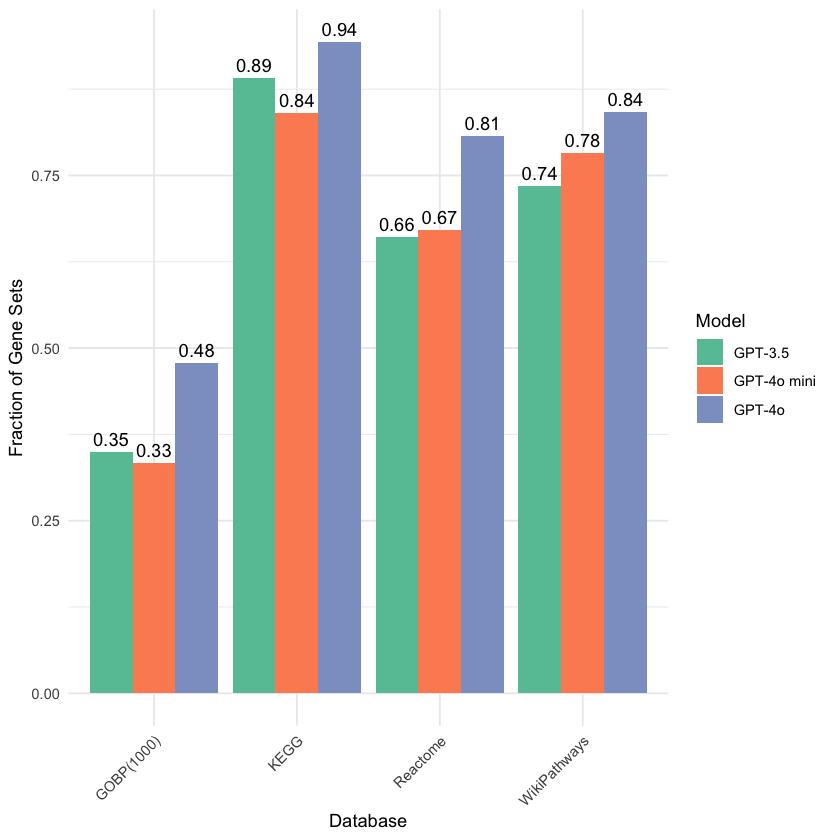

In [61]:

# Step 4: Group by 'database' and 'model' and calculate the fraction of p_val_adj < 0.01
fraction_df <- df %>%
  group_by(database, model) %>%
  summarize(fraction_below_0_01 = mean(p_val_adj < 0.01)) %>%
  ungroup()  # Ungroup to avoid issues with subsequent operations

# Step 5: Create the bar plot grouped by 'database' and colored by 'model', with fraction above each bar
p <- ggplot(fraction_df, aes(x = database, y = fraction_below_0_01, fill = model)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create grouped bar plot
  geom_text(aes(label = round(fraction_below_0_01, 2)),  # Add text with the rounded fraction
            position = position_dodge(width = 0.9),      # Adjust position for dodged bars
            vjust = -0.5) +                              # Move the text above the bars
  theme_minimal() +  # Use a minimal theme
  labs(x = "Database", y = "Fraction of Gene Sets") +  # Update y-axis label
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for readability
  scale_fill_brewer(palette = "Set2", name = "Model")  # Set color palette for models

p

In [62]:
ggsave(p, file="figures/fig1c.pdf", width=7,height=5)

## Figure 1D

In [70]:
df <- readr::read_tsv("outputs/genes_overlap.tsv")
df <- df %>% filter(gene_set == "llm_genes_role")
# Step 1: Update model names
df <- df %>%
  mutate(model = case_when(
    model == "gpt-4o-mini-2024-07-18" ~ "GPT-4o mini",
    model == "gpt-3.5-turbo-0125" ~ "GPT-3.5",
    model == "gpt-4o-2024-08-06" ~ "GPT-4o",
    TRUE ~ model  # Leave other values unchanged
  ))

# Step 2: Update database names
df <- df %>%
  mutate(database = case_when(
    database == "KEGG_2021_Human" ~ "KEGG",
    database == "Reactome_2022" ~ "Reactome",
    database == "WikiPathway_2023_Human" ~ "WikiPathways",
    database == "GO_Biological_Process_2023_sample1000" ~ "GOBP(1000)",
    TRUE ~ database  # Leave other values unchanged
  ))

# Step 3: Set the order of the 'model' factor
df <- df %>%
  mutate(model = factor(model, levels = c("GPT-3.5", "GPT-4o mini", "GPT-4o")))


Rows: 82719 Columns: 17
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): database, model, gene_set, descr, descr_cleaned
dbl (12): ncurated, nllm, ninter, generatio, bgratio, richFactor, foldEnrich...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [71]:
# Assuming df is the data frame with columns database, model, descr, and p_val
# Step 1: Select the relevant columns
df_selected <- df %>%
  select(database, model, descr, p_val)

# Step 2: Reshape the data so that each value of 'model' is in a separate column
df_wide <- df_selected %>%
  pivot_wider(names_from = model, values_from = p_val)

# View the reshaped data
df_wide <- df_wide %>%
  rename(
    GPT4o_mini = `GPT-4o mini`,       # Rename 'GPT-4o mini' to 'GPT4o_mini'
    GPT3_5 = `GPT-3.5`,               # Rename 'GPT-3.5' to 'GPT3_5'
    GPT4o = `GPT-4o`                  # Rename 'GPT-4o' to 'GPT4o'
  )

head(df_wide)

database,descr,GPT4o_mini,GPT3_5,GPT4o
<chr>,<chr>,<dbl>,<dbl>,<dbl>
KEGG,ABC transporters,3.079999e-68,1.224149e-27,3.478219e-115
KEGG,AGE-RAGE signaling pathway in diabetic complications,3.742895e-14,5.418608e-30,1.181686e-25
KEGG,AMPK signaling pathway,1.444675e-24,4.846371e-38,8.191621e-66
KEGG,Acute myeloid leukemia,7.350817e-09,9.488063e-09,2.570267e-10
KEGG,Adherens junction,1.992364e-07,1.869181e-08,3.183117e-20
KEGG,Adipocytokine signaling pathway,4.841744e-19,7.036167e-45,3.256808e-25


`summarise()` has grouped output by 'database'. You can override using the `.groups` argument.


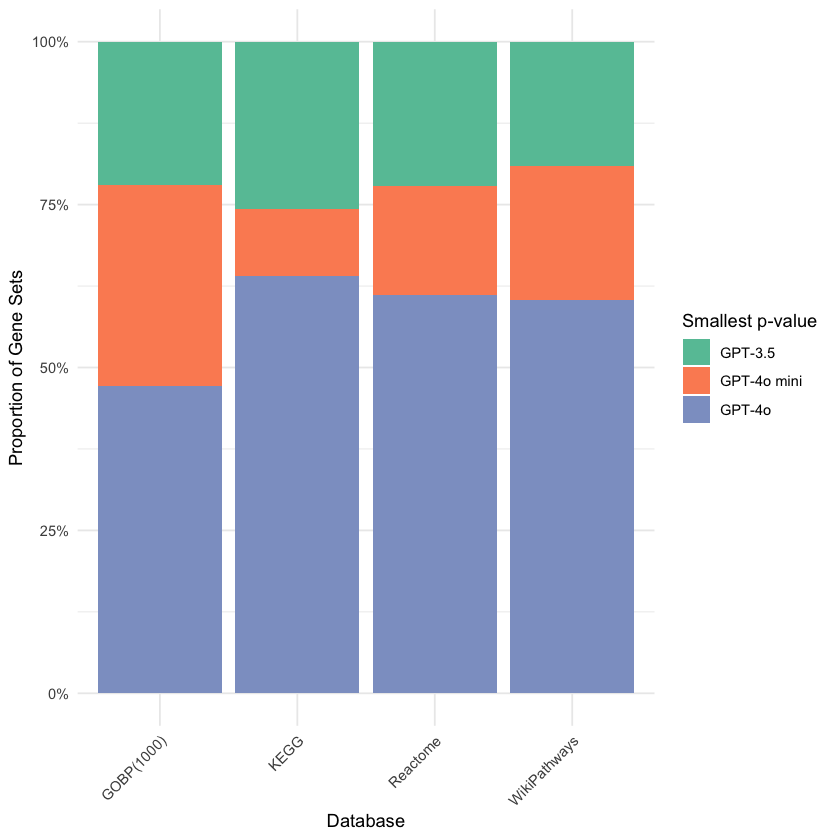

In [72]:
df_wide <- df_wide %>%
  mutate(
    smallest_column = case_when(
      GPT4o_mini == pmin(GPT4o_mini, GPT3_5, GPT4o) ~ "GPT4o_mini",
      GPT3_5 == pmin(GPT4o_mini, GPT3_5, GPT4o) ~ "GPT3_5",
      GPT4o == pmin(GPT4o_mini, GPT3_5, GPT4o) ~ "GPT4o"
    )
  )


df_wide <- df_wide %>%
  mutate(smallest_column = case_when(
    smallest_column == "GPT3_5" ~ "GPT-3.5",
    smallest_column == "GPT4o_mini" ~ "GPT-4o mini",
    smallest_column == "GPT4o" ~ "GPT-4o",
    TRUE ~ smallest_column  # Leave other values unchanged
  ))
# Step 3: Set the order of the 'model' factor
df_wide <- df_wide %>%
  mutate(smallest_column = factor(smallest_column, 
                                  levels = c("GPT-3.5", "GPT-4o mini", "GPT-4o")))

# Step 1: Group by 'database' and 'smallest_column' and count occurrences
df_proportional <- df_wide %>%
  group_by(database, smallest_column) %>%
  summarize(count = n()) %>%
  mutate(proportion = count / sum(count)) %>%
  ungroup()

# Step 2: Generate the proportional bar plot using ggplot2 with Set2 color scheme
p <- ggplot(df_proportional, aes(x = database, y = proportion, fill = smallest_column)) +
  geom_bar(stat = "identity", position = "fill") +  # Create proportional bar plot
  labs(x = "Database", y = "Proportion of Gene Sets", fill = "Smallest p-value") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  scale_y_continuous(labels = scales::percent_format()) +  # Show proportions as percentages
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for readability
  scale_fill_brewer(palette = "Set2")  # Apply Set2 color scheme
p

In [73]:
ggsave(p, file="figures/fig1d.pdf", width=5, height=5)

## Figure S1C

In [126]:
df <- readr::read_tsv("outputs/genes_overlap.tsv")
df <- df %>% filter(gene_set %in%  c("llm_genes_role", "llm_genes_norole") )
# Step 1: Update model names
df <- df %>%
  mutate(model = case_when(
    model == "gpt-4o-mini-2024-07-18" ~ "GPT-4o mini",
    model == "gpt-3.5-turbo-0125" ~ "GPT-3.5",
    model == "gpt-4o-2024-08-06" ~ "GPT-4o",
    TRUE ~ model  # Leave other values unchanged
  ))

# Step 2: Update database names
df <- df %>%
  mutate(database = case_when(
    database == "KEGG_2021_Human" ~ "KEGG",
    database == "Reactome_2022" ~ "Reactome",
    database == "WikiPathway_2023_Human" ~ "WikiPathways",
    database == "GO_Biological_Process_2023_sample1000" ~ "GOBP(1000)",
    TRUE ~ database  # Leave other values unchanged
  ))

# Step 3: Set the order of the 'model' factor
df <- df %>%
  mutate(model = factor(model, levels = c("GPT-3.5", "GPT-4o mini", "GPT-4o")))


Rows: 82719 Columns: 17
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): database, model, gene_set, descr, descr_cleaned
dbl (12): ncurated, nllm, ninter, generatio, bgratio, richFactor, foldEnrich...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


`summarise()` has grouped output by 'database', 'model'. You can override using the `.groups` argument.


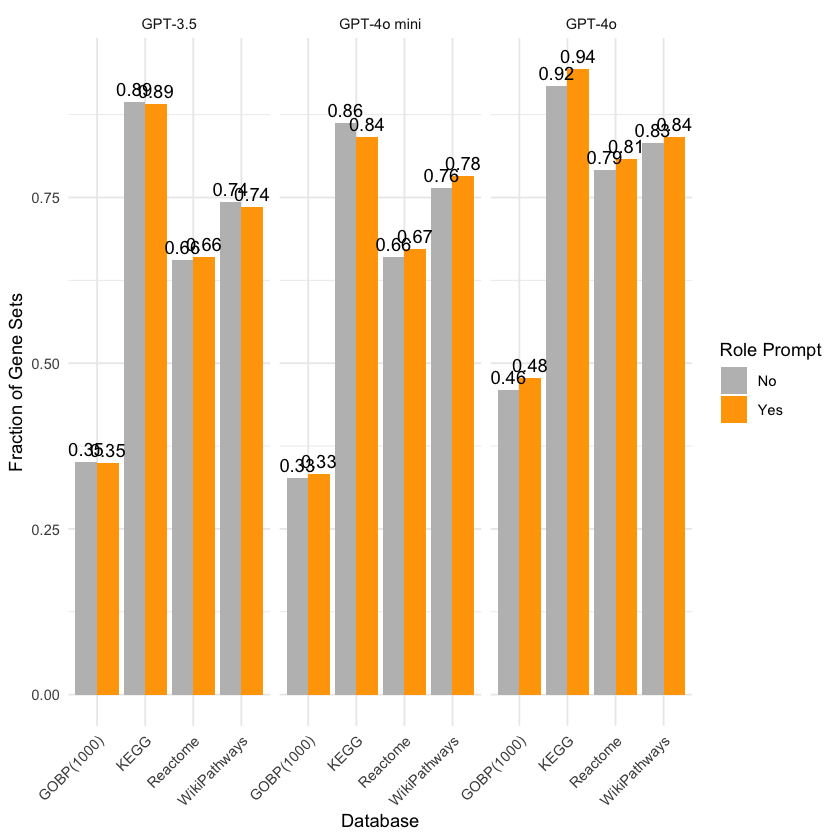

In [127]:
# Step 1: Group by 'database', 'model', and 'gene_set' and calculate the proportion of p_val_adj < 0.01
df_proportion <- df %>%
  group_by(database, model, gene_set) %>%
  summarize(proportion = mean(p_val_adj < 0.01)) %>%
  ungroup()

# Step 2: Replace values in 'gene_set' for better legend display
df_proportion <- df_proportion %>%
  mutate(gene_set = case_when(
    gene_set == "llm_genes_norole" ~ "No",
    gene_set == "llm_genes_role" ~ "Yes",
    TRUE ~ gene_set  # Keep other values unchanged
  ))

# Step 3: Create a bar plot faceted by 'model' with gene_set for fill and a custom color palette
p <- ggplot(df_proportion, aes(x = database, y = proportion, fill = gene_set)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create grouped bar plot (side-by-side bars)
  geom_text(aes(label = round(proportion, 2)),      # Add rounded proportions as labels
            position = position_dodge(width = 0.9), vjust = -0.5) +  # Adjust label position
  theme_minimal() +  # Use a minimal theme
  labs(x = "Database", y = "Fraction of Gene Sets", fill = "Role Prompt") +  # Set axis and legend labels
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for readability
  facet_wrap(~ model) +  # Facet by 'model'
  scale_fill_manual(values = c("No" = "gray", "Yes" = "orange"))  

p

In [133]:
ggsave(p, file="figures/figS1C.pdf", width=11.5, height=5)

## Figure S1D - HGCN gene symbols

In [121]:
df <- readr::read_tsv("outputs/genes_overlap.tsv")
df <- df %>% filter(gene_set %in%  c("llm_genes_role") )
# Step 1: Update model names
df <- df %>%
  mutate(model = case_when(
    model == "gpt-4o-mini-2024-07-18" ~ "GPT-4o mini",
    model == "gpt-3.5-turbo-0125" ~ "GPT-3.5",
    model == "gpt-4o-2024-08-06" ~ "GPT-4o",
    TRUE ~ model  # Leave other values unchanged
  ))

# Step 2: Update database names
df <- df %>%
  mutate(database = case_when(
    database == "KEGG_2021_Human" ~ "KEGG",
    database == "Reactome_2022" ~ "Reactome",
    database == "WikiPathway_2023_Human" ~ "WikiPathways",
    database == "GO_Biological_Process_2023_sample1000" ~ "GOBP(1000)",
    TRUE ~ database  # Leave other values unchanged
  ))

# Step 3: Set the order of the 'model' factor
df <- df %>%
  mutate(model = factor(model, levels = c("GPT-3.5", "GPT-4o mini", "GPT-4o")))

# Compute the percentage of "descr" that is not HGNC genes, formula non_hgcn/nllm
percentage_df <- df %>%
  filter(gene_set == "llm_genes_role") %>%
  group_by(database, model) %>%
  summarise(percentage = (1-sum(non_hgnc) / sum(nllm)) * 100,.groups = 'drop')
percentage_df


Rows: 82719 Columns: 17
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): database, model, gene_set, descr, descr_cleaned
dbl (12): ncurated, nllm, ninter, generatio, bgratio, richFactor, foldEnrich...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


database,model,percentage
<chr>,<fct>,<dbl>
GOBP(1000),GPT-3.5,87.76495
GOBP(1000),GPT-4o mini,87.78350
GOBP(1000),GPT-4o,95.09859
KEGG,GPT-3.5,88.11907
KEGG,GPT-4o mini,88.31169
KEGG,GPT-4o,94.09323
Reactome,GPT-3.5,87.73508
Reactome,GPT-4o mini,88.01658
Reactome,GPT-4o,94.36847


`summarise()` has grouped output by 'database'. You can override using the `.groups` argument.


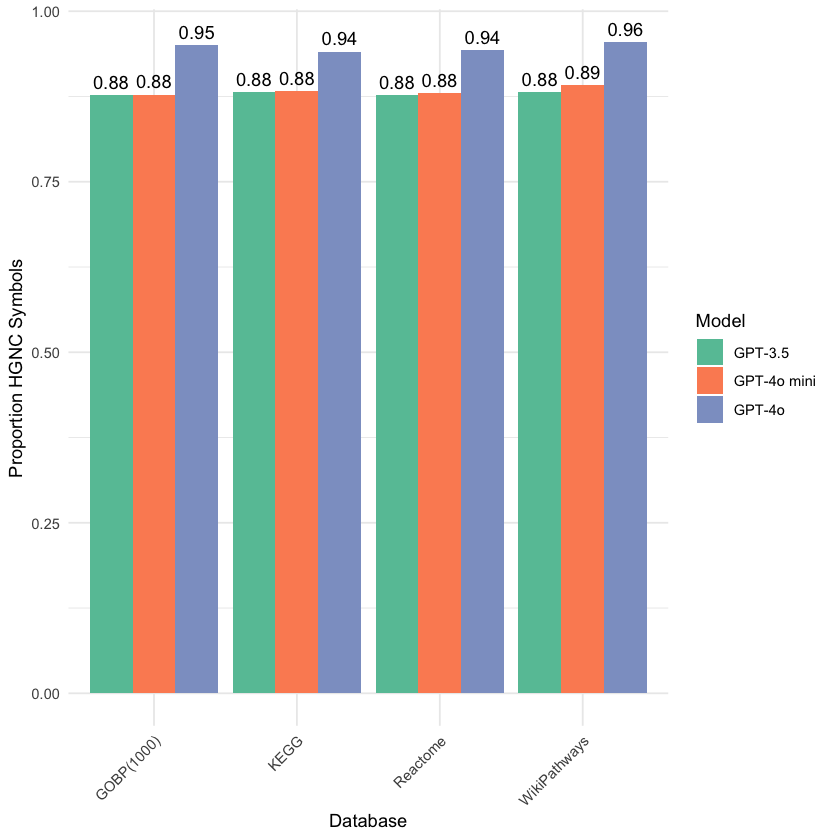

In [122]:
# Step 1: Group by 'database' and 'model', compute the sum for 'non_hgnc' and 'nllm'
df_grouped <- df %>%
  group_by(database, model) %>%
  summarize(
    sum_non_hgnc = sum(non_hgnc, na.rm = TRUE),  # Sum of non_hgnc
    sum_nllm = sum(nllm, na.rm = TRUE)  # Sum of nllm
  ) %>%
  ungroup()  # Ungroup the data frame

# Step 2: Compute the ratio '1 - (sum_non_hgnc / sum_nllm)'
df_grouped <- df_grouped %>%
  mutate(ratio = 1 - (sum_non_hgnc / sum_nllm))

# Step 3: Create a bar plot with 'database' on the x-axis, 'ratio' on the y-axis, grouped by 'model'
p <- ggplot(df_grouped, aes(x = database, y = ratio, fill = model)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create grouped bar plot (side-by-side bars)
  geom_text(aes(label = round(ratio, 2)),             # Add rounded values on top of the bars
            position = position_dodge(width = 0.9), 
            vjust = -0.5) +                           # Adjust the vertical position of the labels
  labs(x = "Database", y = "Proportion HGNC Symbols", fill = "Model") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for readability
  scale_fill_brewer(palette = "Set2")  # Use Set2 color scheme for the bars
p

In [118]:
ggsave(p, file="figures/figS1D.pdf", width=6.75,heigh=4.75)

## Figure S1E

`summarise()` has grouped output by 'database'. You can override using the `.groups` argument.


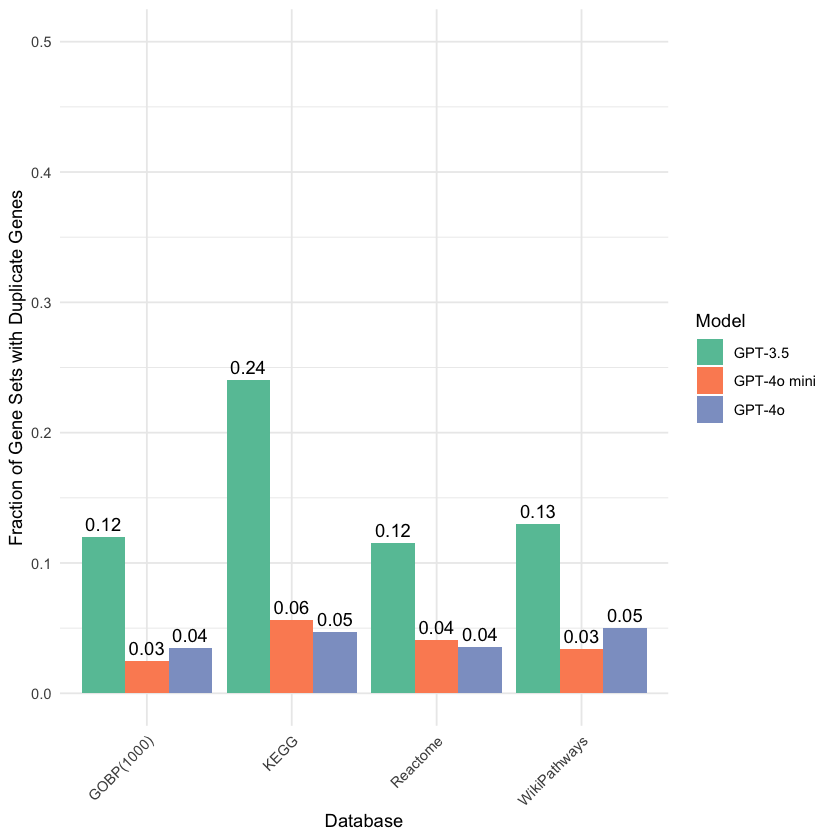

In [119]:

# Step 1: Group by 'database' and 'model' and calculate the fraction where 'ndup > 0'
df_fraction <- df %>%
  group_by(database, model) %>%
  summarize(fraction_ndup_gt_0 = mean(ndup > 0, na.rm = TRUE)) %>%
  ungroup()

# Step 2: Create a bar plot with 'database' on the x-axis and the fraction on the y-axis, grouped by 'model'
p <- ggplot(df_fraction, aes(x = database, y = fraction_ndup_gt_0, fill = model)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create grouped bar plot (side-by-side bars)
  geom_text(aes(label = round(fraction_ndup_gt_0, 2)),  # Add the fraction on top of the bars
            position = position_dodge(width = 0.9), 
            vjust = -0.5) +  # Adjust vertical position of the labels
  scale_y_continuous(limits = c(0, 0.5)) +  # Set the y-axis limits between 0 and 0.5
  labs(x = "Database", y = "Fraction of Gene Sets with Duplicate Genes", fill = "Model") +  # Update axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for readability
  scale_fill_brewer(palette = "Set2")  # Use Set2 color scheme for the bars
p

In [120]:
ggsave(p, file="figures/figS1E.pdf", width=6.75,heigh=4.75)

## Figure S1F

In [112]:
df <- readr::read_tsv("outputs/tok_use.tsv")
df <- df %>% filter(gene_set %in%  c("llm_genes_role") )
# Step 1: Update model names
df <- df %>%
  mutate(model = case_when(
    model == "gpt-4o-mini-2024-07-18" ~ "GPT-4o mini",
    model == "gpt-3.5-turbo-0125" ~ "GPT-3.5",
    model == "gpt-4o-2024-08-06" ~ "GPT-4o",
    TRUE ~ model  # Leave other values unchanged
  ))
df
# Step 2: Update database names
df <- df %>%
  mutate(lib_name = case_when(
    lib_name == "KEGG_2021_Human" ~ "KEGG",
    lib_name == "Reactome_2022" ~ "Reactome",
    lib_name == "WikiPathway_2023_Human" ~ "WikiPathways",
    lib_name == "GO_Biological_Process_2023_sample1000" ~ "GOBP(1000)",
    TRUE ~ lib_name  # Leave other values unchanged
  ))


# Step 3: Set the order of the 'model' factor
df <- df %>%
  mutate(model = factor(model, levels = c("GPT-3.5", "GPT-4o mini", "GPT-4o")))

df

Rows: 84 Columns: 5
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): lib_name, model, gene_set
dbl (2): in_toks, out_toks

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


lib_name,model,gene_set,in_toks,out_toks
<chr>,<chr>,<chr>,<dbl>,<dbl>
KEGG_2021_Human,GPT-4o mini,llm_genes_role,55292,80365
KEGG_2021_Human,GPT-3.5,llm_genes_role,54840,84445
KEGG_2021_Human,GPT-4o,llm_genes_role,55292,95722
Reactome_2022,GPT-4o mini,llm_genes_role,328686,405673
Reactome_2022,GPT-3.5,llm_genes_role,326126,317823
Reactome_2022,GPT-4o,llm_genes_role,328686,454958
WikiPathway_2023_Human,GPT-4o mini,llm_genes_role,144688,181465
WikiPathway_2023_Human,GPT-3.5,llm_genes_role,143878,162885
WikiPathway_2023_Human,GPT-4o,llm_genes_role,144688,199598


lib_name,model,gene_set,in_toks,out_toks
<chr>,<fct>,<chr>,<dbl>,<dbl>
KEGG,GPT-4o mini,llm_genes_role,55292,80365
KEGG,GPT-3.5,llm_genes_role,54840,84445
KEGG,GPT-4o,llm_genes_role,55292,95722
Reactome,GPT-4o mini,llm_genes_role,328686,405673
Reactome,GPT-3.5,llm_genes_role,326126,317823
Reactome,GPT-4o,llm_genes_role,328686,454958
WikiPathways,GPT-4o mini,llm_genes_role,144688,181465
WikiPathways,GPT-3.5,llm_genes_role,143878,162885
WikiPathways,GPT-4o,llm_genes_role,144688,199598


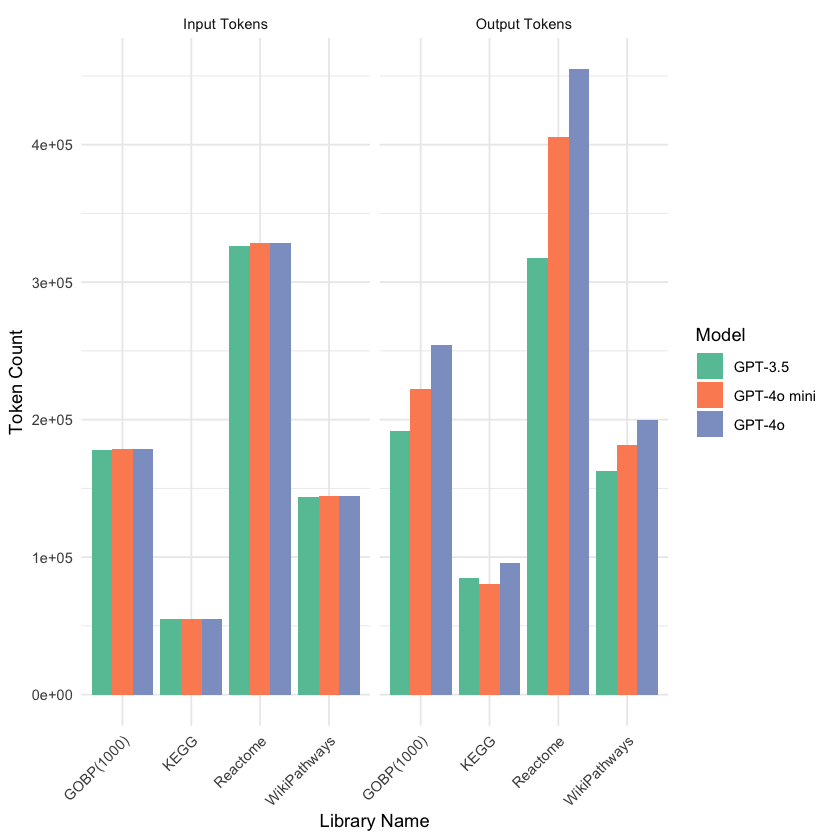

In [113]:

# Step 1: Reshape the data to gather 'in_toks' and 'out_toks' into a single column
df_long <- df %>%
  pivot_longer(cols = c(in_toks, out_toks), names_to = "token_type", values_to = "token_count")

# Step 2: Create a custom labeller function to relabel facet titles
facet_labels <- c("in_toks" = "Input Tokens", "out_toks" = "Output Tokens")

# Step 3: Create a bar plot grouped by 'lib_name' and 'model', with facets for 'in_toks' and 'out_toks'
p <- ggplot(df_long, aes(x = lib_name, y = token_count, fill = model)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create grouped bar plot (side-by-side bars)
  facet_wrap(~ token_type, labeller = as_labeller(facet_labels)) +  # Custom facet labels
  labs(x = "Library Name", y = "Token Count", fill = "Model") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for readability
  scale_fill_brewer(palette = "Set2")  # Apply Set2 color palette to the fill
p

In [114]:
ggsave(p, file="figures/figS1F.pdf",width=6.75,heigh=4.75)

In [115]:
# Compute the sum of 'in_toks' and 'out_toks' for each 'model'
df_sum <- df %>%
  group_by(model) %>%
  summarize(
    sum_in_toks = sum(in_toks, na.rm = TRUE),   # Sum of 'in_toks'
    sum_out_toks = sum(out_toks, na.rm = TRUE)  # Sum of 'out_toks'
  )

# View the result
df_sum

model,sum_in_toks,sum_out_toks
<fct>,<dbl>,<dbl>
GPT-3.5,702956,756728
GPT-4o mini,707058,889924
GPT-4o,707402,1004497
